In [1]:
import pandas as pd
from src.analysis import clustering_utils
import networkx as nx
from src.graph.graph_util import *
import config.config as config
from cdlib import algorithms
from IPython.display import display

import dill
dill.load_session("02_session.pkl")

Note: to be able to use all crisp methods, you need to install some additional packages:  {'infomap', 'graph_tool', 'leidenalg', 'bayanpy', 'wurlitzer'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'pyclustering', 'ASLPAw'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'infomap', 'wurlitzer', 'leidenalg'}


# Clustering Analysis

I will employ the following Community Discovery algorithms:

- **Angel (Percolation)**, node-centric bottom up approach. Use the assumption that locally each node is able to identify its community but globally we are tangled in complex overlaps (this is generally true for PPI networks). Quoting the docs "Angel is the, faster, successor of Demon."
- **Infomap (Entity Closeness)**, similar to Louvain, exploits the notions of conductance, minimum descriptive lengths and random walkers. Low conductance means few bridges thus well separated communities
- **Louvain (Internal Density)**, exploits the notion of modularity in order to build the different communities.

## Loading the networks

In [2]:
downregulated_graph = get_gene_graph([], config.LIVER_DOWNREGULATED_GRAPH_FILE_NAME)
upregulated_graph = get_gene_graph([], config.LIVER_UPREGULATED_GRAPH_FILE_NAME)
combined_graph = nx.compose(downregulated_graph, upregulated_graph)
combined_graph.number_of_nodes(), combined_graph.number_of_edges()

Loaded graph '/home/emiliano/Desktop/Università/Network Analysis/Project/Code/data/graphs/liver_downregulated_graph': 6858 nodes, 21862 edges
Loaded graph '/home/emiliano/Desktop/Università/Network Analysis/Project/Code/data/graphs/liver_upregulated_graph': 5871 nodes, 17408 edges


(8795, 32313)

In [3]:
combined_graph = combined_graph.subgraph(max(nx.connected_components(combined_graph), key=len)).copy()
combined_graph.number_of_nodes(), combined_graph.number_of_edges()

(8408, 32178)

# Enrichment Strategy
For each partition provided by the algorithms, i am going to perform **gene set enrichment** (for Pathways (KEGG) and Gene Ontology Function) and evaluate the enrichment by taking into account:
- **False Discovery Rate** (FDR) - the lowest the better - measures how unlikely it is thata the overlap occurred by chance. It is a statistical significance measure, kind like an adjuste p-value.
- **Number of background genes > 2** - to avoid small background that might mess the enrichment ratio
- **Enrichment Ratio** (n_genes / n_genes_in_background) - this measures how strong is the enrichment for that particular category. n_genes define the number of genes from the background (the partition) that belongs to that specific pathway/function.

I will select the enrichment that shows the lowest FDR and the highest Enrichment Ratio for each of the two categories i have chosen (KEGG and Function).

## Percolation (Angel)

In [23]:
angel = algorithms.angel(combined_graph, threshold=0.25)

In [24]:
background_genes = {data["name"] for node, data in combined_graph.nodes(data=True)}
angel_metadata = clustering_utils.get_partitioning_metadata(angel, background_genes, verbose=True)

Partitioning Metadata:
	Number of communities: 49
	Average community size: 117.45
	Internal edge density: FitnessResult(min=0.0019697443355578812, max=1.0, score=np.float64(0.5414805080122445), std=np.float64(0.2207873729926872))
	Average internal degree: FitnessResult(min=1.5, max=11.75, score=np.float64(5.641204860734922), std=np.float64(2.6962444953385543))
	Modularity density: FitnessResult(min=None, max=None, score=np.float64(182.66447053261362), std=None)
	Conductance: FitnessResult(min=0.029411764705882353, max=0.8, score=np.float64(0.2802128764400645), std=np.float64(0.1845962246122948))


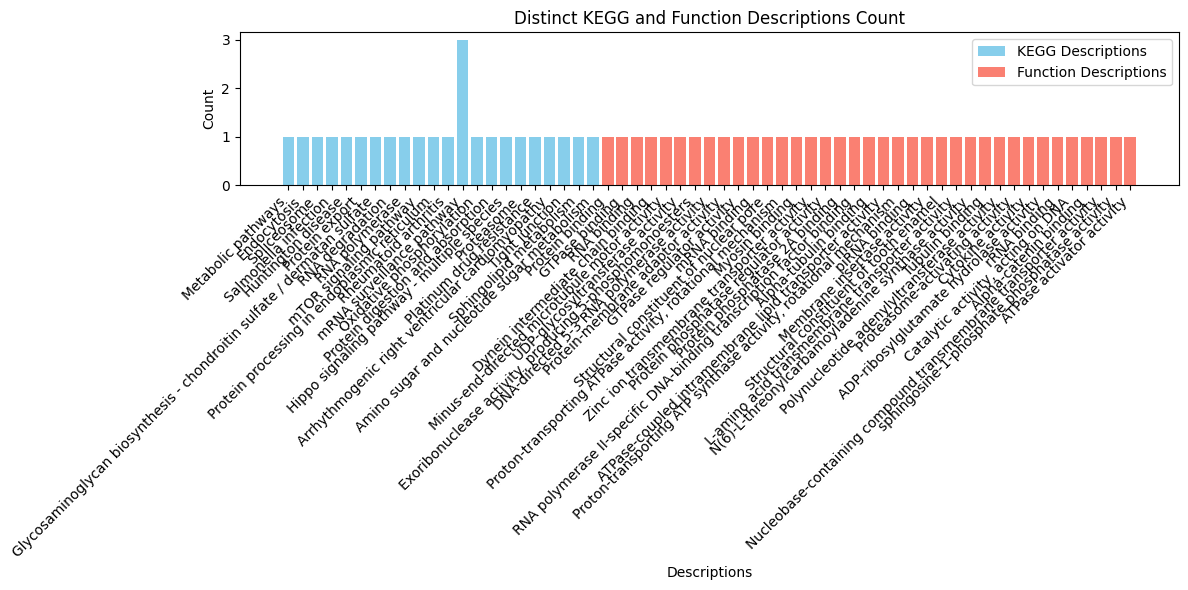

In [4]:
clustering_utils.plot_partitioning_enrichment(angel_metadata)

## Entity Closeness (Infomap)

In [26]:
infomap = algorithms.infomap(combined_graph)

In [27]:
infomap_metadata = clustering_utils.get_partitioning_metadata(infomap, background_genes, verbose=True)

KeyboardInterrupt: 

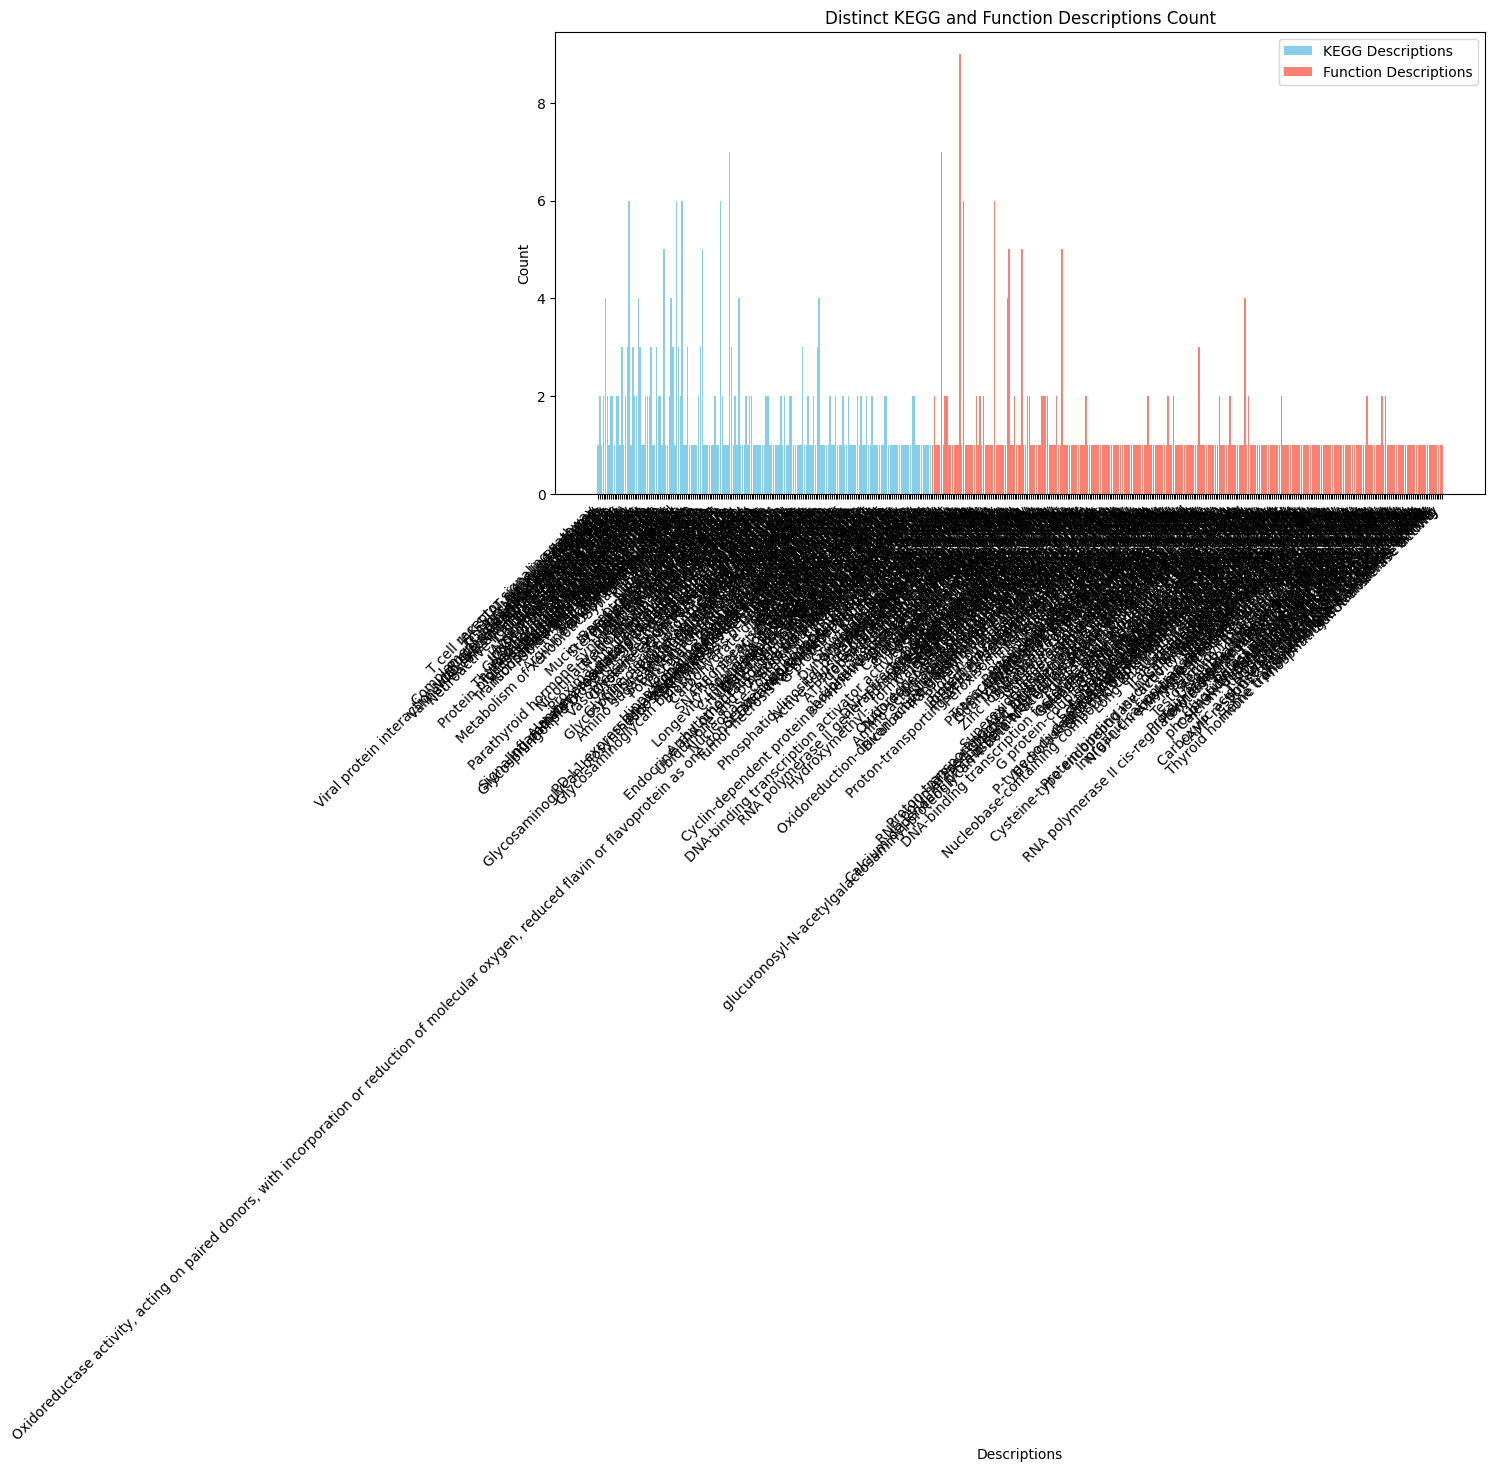

In [5]:
clustering_utils.plot_partitioning_enrichment(infomap_metadata)

## Internal Density (Louvain)

In [8]:
louvain = algorithms.louvain(g_original=combined_graph)

In [9]:
louvain_metadata = clustering_utils.get_partitioning_metadata(louvain, background_genes, verbose=True)

Partitioning Metadata:
	Number of communities: 349
	Average community size: 25.20
	Internal edge density: FitnessResult(min=0, max=1.0, score=np.float64(0.08941714824648014), std=np.float64(0.25109635238751987))
	Average internal degree: FitnessResult(min=0.0, max=9.333333333333334, score=np.float64(1.0065915264142238), std=np.float64(2.248512665486997))
	Modularity density: FitnessResult(min=None, max=None, score=np.float64(302.42304462420725), std=None)
	Conductance: FitnessResult(min=0.0, max=0.24583741429970618, score=np.float64(0.018707024595859843), std=np.float64(0.05186612920846718))


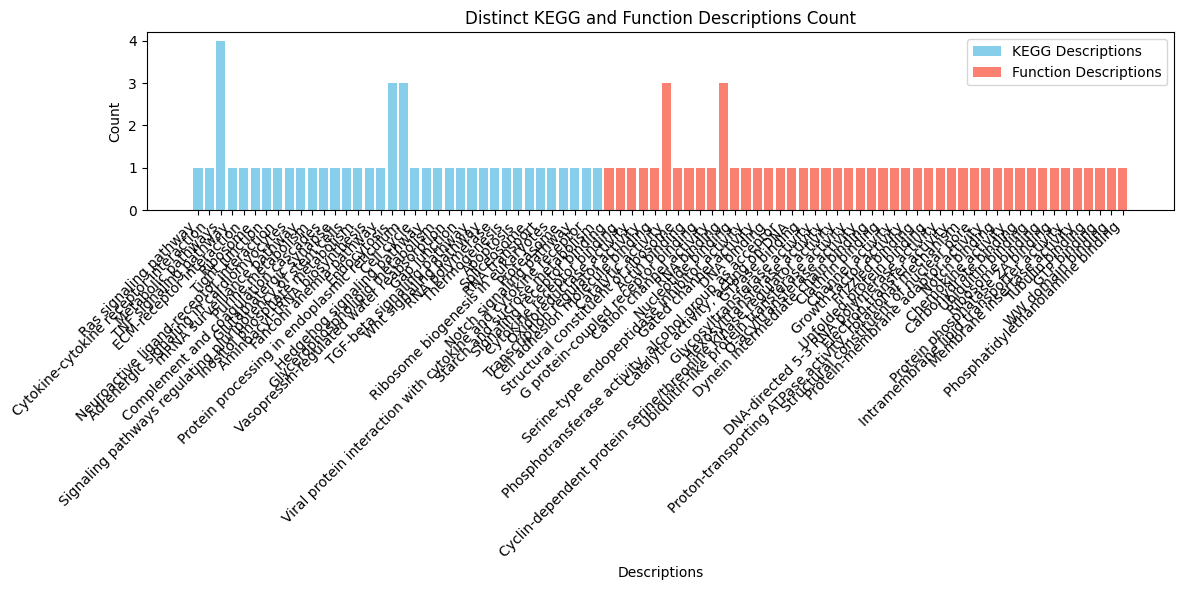

In [25]:
clustering_utils.plot_partitioning_enrichment(louvain_metadata)

# Partitioning Comparison Table

In [38]:
data = {
    "Method": ["Angel", "Infomap", "Louvain"],
    "n_clusters": [angel_metadata["num_communities"], infomap_metadata["num_communities"], louvain_metadata["num_communities"]],
    "avg_cluster_size": [angel_metadata["avg_community_size"], infomap_metadata["avg_community_size"], louvain_metadata["avg_community_size"]],
    "min_internal_edge_density": [angel_metadata["internal_edge_density"].min, infomap_metadata["internal_edge_density"].min, louvain_metadata["internal_edge_density"].min],
    "min_average_internal_degree": [angel_metadata["average_internal_degree"].min, infomap_metadata["average_internal_degree"].min, louvain_metadata["average_internal_degree"].min],
    "modularity_score": [angel_metadata["modularity_density"].score, infomap_metadata["modularity_density"].score, louvain_metadata["modularity_density"].score],
    "max_conductance": [angel_metadata["conductance"].max, infomap_metadata["conductance"].max, louvain_metadata["conductance"].max],
    "n_distinct_kegg_terms": [len(angel_metadata["distinct_kegg_descriptions_count"].keys()), len(infomap_metadata["distinct_kegg_descriptions_count"].keys()), len(louvain_metadata["distinct_kegg_descriptions_count"].keys())],
    "n_distinct_go_terms": [len(angel_metadata["distinct_function_descriptions_count"].keys()), len(infomap_metadata["distinct_function_descriptions_count"].keys()), len(louvain_metadata["distinct_function_descriptions_count"].keys())],
    "avg_kegg_coverage": [clustering_utils.average_enrichment_coverage(angel_metadata)[0], clustering_utils.average_enrichment_coverage(infomap_metadata)[0], clustering_utils.average_enrichment_coverage(louvain_metadata)[0]],
    "avg_go_coverage": [clustering_utils.average_enrichment_coverage(angel_metadata)[1], clustering_utils.average_enrichment_coverage(infomap_metadata)[1], clustering_utils.average_enrichment_coverage(louvain_metadata)[1]]
}

df = pd.DataFrame(data)

# Simple table in Jupyter
display(df)

,Method,n_clusters,avg_cluster_size,min_internal_edge_density,min_average_internal_degree,modularity_score,max_conductance,n_distinct_kegg_terms,n_distinct_go_terms,avg_kegg_coverage,avg_go_coverage
0,Angel,50,115.480000,0.001997,1.5,190.400918,0.684211,22,37,0.192413,0.301644
1,Infomap,740,11.885135,0.000000,0.0,1154.866381,0.750000,183,280,0.172437,0.260103
2,Louvain,349,25.200573,0.000000,0.0,302.423045,0.245837,36,46,0.393345,0.260211


How do we select the best algorithm? We will build a scoring function, assigning each term a different weight based on how i belive it is relevant, normalizing the data and the outputting the score for each algorithm.

I want something like this:
- n_clusters must be a good trade off, not too big neither too low. A good balance might indicate a good clustering.
- avg_cluster_size should be as high as possible, it indicates a good clustering.
- for internal_edge_density, average_internal_degree and modularity we want to have the **best-worst case**, so we want the maximum among the minimums.
- while for conductance we do the opposite. We take the minimum among the maximum values.
- for n_distinct_kegg_terms and go_terms we want it to be as low as possible, this means that the clustering is much more meaningful since the nodes have the same biological function
- while for the coverages of kegg and go we want them to be as high as possible.

In [18]:
weights = {
    'n_clusters': 0.10,
    'avg_cluster_size': 0.10,
    'min_internal_edge_density': 0.05,
    'min_average_internal_degree': 0.05,
    'modularity_score': 0.05,
    'max_conductance': 0.05,
    'n_distinct_kegg_terms': 0.15,
    'n_distinct_go_terms': 0.15,
    'avg_kegg_coverage': 0.15,
    'avg_go_coverage': 0.15
}

scored_df = clustering_utils.score_partitionings(df, weights)
display(scored_df.sort_values(by="score", ascending=False))

,Method,n_clusters,avg_cluster_size,min_internal_edge_density,min_average_internal_degree,modularity_score,max_conductance,n_distinct_kegg_terms,n_distinct_go_terms,avg_kegg_coverage,avg_go_coverage,score
0,Angel,1.000000,1.000000,1.0,1.0,0.000000,0.130493,1.000000,1.000000,0.090423,1.000000,0.770088
2,Louvain,0.566667,0.128534,0.0,0.0,0.116149,1.000000,0.913043,0.962963,1.000000,0.002585,0.557116
1,Infomap,0.000000,0.000000,0.0,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.050000


In [15]:
community_fold_changes = {}
for i, community in enumerate(angel.communities):
    fc_down_sum = 0
    fc_up_sum = 0
    fc_down_num = 0
    fc_up_num = 0
    for node, data in combined_graph.subgraph(community).nodes(data=True):
        if data["fold_change"] < 0:
            fc_down_sum += data["fold_change"]
            fc_down_num += 1
        else:
            fc_up_sum += data["fold_change"]
            fc_up_num += 1
    community_fold_changes[i] = {
        "nodes": len(community),
        "fc_down_sum": fc_down_sum,
        "fc_down_num": fc_down_num,
        "fc_up_sum": fc_up_sum,
        "fc_up_num": fc_up_num
    }

community_fold_changes

{0: {'nodes': 5028,
  'fc_down_sum': -498.0805773297479,
  'fc_down_num': 259,
  'fc_up_sum': 389.15571320615766,
  'fc_up_num': 4769},
 1: {'nodes': 62,
  'fc_down_sum': -2.350358084291805,
  'fc_down_num': 2,
  'fc_up_sum': 0.7604026262181234,
  'fc_up_num': 60},
 2: {'nodes': 62,
  'fc_down_sum': 0,
  'fc_down_num': 0,
  'fc_up_sum': 4.393868362149622,
  'fc_up_num': 62},
 3: {'nodes': 56,
  'fc_down_sum': -1.7372696571908977,
  'fc_down_num': 1,
  'fc_up_sum': 2.1098958291606245,
  'fc_up_num': 55},
 4: {'nodes': 31,
  'fc_down_sum': -4.278526881003539,
  'fc_down_num': 1,
  'fc_up_sum': 1.029305758236858,
  'fc_up_num': 30},
 5: {'nodes': 27,
  'fc_down_sum': -1.7482069576525556,
  'fc_down_num': 2,
  'fc_up_sum': 0.0,
  'fc_up_num': 25},
 6: {'nodes': 26,
  'fc_down_sum': -2.8445673846253365,
  'fc_down_num': 3,
  'fc_up_sum': 0.6298668657788745,
  'fc_up_num': 23},
 7: {'nodes': 26,
  'fc_down_sum': 0,
  'fc_down_num': 0,
  'fc_up_sum': 3.4941957801053345,
  'fc_up_num': 26},
 8

In [16]:
community_fold_changes = {}
for i, community in enumerate(infomap.communities):
    fc_down_sum = 0
    fc_up_sum = 0
    fc_down_num = 0
    fc_up_num = 0
    for node, data in combined_graph.subgraph(community).nodes(data=True):
        if data["fold_change"] < 0:
            fc_down_sum += data["fold_change"]
            fc_down_num += 1
        else:
            fc_up_sum += data["fold_change"]
            fc_up_num += 1
    community_fold_changes[i] = {
        "nodes": len(community),
        "fc_down_sum": fc_down_sum,
        "fc_down_num": fc_down_num,
        "fc_up_sum": fc_up_sum,
        "fc_up_num": fc_up_num
    }

community_fold_changes

{0: {'nodes': 100,
  'fc_down_sum': -41.35775650474541,
  'fc_down_num': 21,
  'fc_up_sum': 0.0,
  'fc_up_num': 79},
 1: {'nodes': 91,
  'fc_down_sum': 0,
  'fc_down_num': 0,
  'fc_up_sum': 6.157327309946474,
  'fc_up_num': 91},
 2: {'nodes': 85,
  'fc_down_sum': -15.67715520454576,
  'fc_down_num': 7,
  'fc_up_sum': 0.0,
  'fc_up_num': 78},
 3: {'nodes': 83,
  'fc_down_sum': -1.9618369133976417,
  'fc_down_num': 1,
  'fc_up_sum': 7.312721997622987,
  'fc_up_num': 82},
 4: {'nodes': 82,
  'fc_down_sum': -6.807454723184218,
  'fc_down_num': 3,
  'fc_up_sum': 5.214798306633304,
  'fc_up_num': 79},
 5: {'nodes': 80,
  'fc_down_sum': 0,
  'fc_down_num': 0,
  'fc_up_sum': 5.1123124631733,
  'fc_up_num': 80},
 6: {'nodes': 79,
  'fc_down_sum': -18.400118718193657,
  'fc_down_num': 8,
  'fc_up_sum': 1.929957600726074,
  'fc_up_num': 71},
 7: {'nodes': 73,
  'fc_down_sum': -11.122368870764696,
  'fc_down_num': 8,
  'fc_up_sum': 1.017516154538305,
  'fc_up_num': 65},
 8: {'nodes': 68,
  'fc_dow

In [17]:
community_fold_changes = {}
for i, community in enumerate(louvain.communities):
    fc_down_sum = 0
    fc_up_sum = 0
    fc_down_num = 0
    fc_up_num = 0
    for node, data in combined_graph.subgraph(community).nodes(data=True):
        if data["fold_change"] < 0:
            fc_down_sum += data["fold_change"]
            fc_down_num += 1
        else:
            fc_up_sum += data["fold_change"]
            fc_up_num += 1
    community_fold_changes[i] = {
        "nodes": len(community),
        "fc_down_sum": fc_down_sum,
        "fc_down_num": fc_down_num,
        "fc_up_sum": fc_up_sum,
        "fc_up_num": fc_up_num
    }

community_fold_changes

{0: {'nodes': 537,
  'fc_down_sum': -99.38189166151243,
  'fc_down_num': 53,
  'fc_up_sum': 24.64229269437026,
  'fc_up_num': 484},
 1: {'nodes': 414,
  'fc_down_sum': -66.12801316094797,
  'fc_down_num': 32,
  'fc_up_sum': 6.292474103988032,
  'fc_up_num': 382},
 2: {'nodes': 371,
  'fc_down_sum': -38.67320498887655,
  'fc_down_num': 7,
  'fc_up_sum': 79.89895379769084,
  'fc_up_num': 364},
 3: {'nodes': 370,
  'fc_down_sum': -19.065332166610446,
  'fc_down_num': 11,
  'fc_up_sum': 46.026545942229696,
  'fc_up_num': 359},
 4: {'nodes': 362,
  'fc_down_sum': -70.89223334143388,
  'fc_down_num': 45,
  'fc_up_sum': 4.961865468952375,
  'fc_up_num': 317},
 5: {'nodes': 333,
  'fc_down_sum': -6.723011368515776,
  'fc_down_num': 4,
  'fc_up_sum': 39.016996628862756,
  'fc_up_num': 329},
 6: {'nodes': 332,
  'fc_down_sum': -8.0735603993573,
  'fc_down_num': 5,
  'fc_up_sum': 21.24684355839746,
  'fc_up_num': 327},
 7: {'nodes': 328,
  'fc_down_sum': -31.524380825694006,
  'fc_down_num': 22,


In [39]:
dill.dump_session("02_session.pkl")